In [ ]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import scvi
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
from rich import print
from scvi.external import CellAssign
import tempfile
import seaborn as sns
import torch
from scipy.cluster.hierarchy import linkage, leaves_list
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/guyshani/Documents/PHD/Aim_2/process_sc/.venv_metacells/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
### scanpy preprocessing
# Load data
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
torch.set_float32_matmul_precision("high")
sc.settings.set_figure_params(dpi=80, facecolor="white")

data_path = "/Users/guyshani/Documents/PHD/Aim_2/PBMC_data/mouse/"
# the file that will store the analysis results
results_file = data_path + "pbmc_mouse.h5ad"

# Load expression matrix
'''
adata = sc.read_10x_mtx(
    "/Users/guyshani/Documents/PHD/Aim_2/PBMC_data/mouse/SC3_v3_NextGem_DI_CellPlex_Mouse_PBMC_10K_PBMCs_mouse_1_count_sample_feature_bc_matrix/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
'''

# Load several datasets
data_path = "/Users/guyshani/Documents/PHD/Aim_2/PBMC_data/mouse/"
samples = {
    "SC3_v3_NextGem_DI_CellPlex_Mouse_PBMC_10K_PBMCs_mouse_1/": "dataset1",
    "sc5p_v2_mm_balbc_T_1k_multi_5gex_t_count_raw/": "dataset2",
    "SC5v2_mousePBMCs_1Kcells_Connect_single_channel/": "dataset3",
    "vdj_nextgem_mm_pbmc4_raw/": "dataset4",
    "vdj_v1_mm_balbc_pbmc_5gex_raw_feature_bc_matrix/": "dataset5",
    "vdj_v1_mm_c57bl6_pbmc_5gex_raw_feature_bc_matrix/": "dataset6",
    "vdj_v1_mm_pbmc4_raw_feature_bc_matrix/": "dataset7"
}
adatas = {}

for sample_id, filename in samples.items():
    path = data_path+sample_id
    sample_adata = sc.read_10x_mtx(path, var_names="gene_symbols", cache=True)
    sample_adata.var_names_make_unique()
    adatas[filename] = sample_adata # Store the AnnData object with its dataset ID

adata = ad.concat(adatas, label="dataset") # Concatenate all datasets into one AnnData object
adata.obs_names_make_unique() # Make cell barcodes unique across samples
print(adata.obs["dataset"].value_counts()) # Print number of cells per sample
adata


scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==1.26.4 scipy==1.15.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13
... reading from cache file cache/Users-guyshani-Documents-PHD-Aim_2-PBMC_data-mouse-SC3_v3_NextGem_DI_CellPlex_Mouse_PBMC_10K_PBMCs_mouse_1-matrix.h5ad
... reading from cache file cache/Users-guyshani-Documents-PHD-Aim_2-PBMC_data-mouse-sc5p_v2_mm_balbc_T_1k_multi_5gex_t_count_raw-matrix.h5ad
... reading from cache file cache/Users-guyshani-Documents-PHD-Aim_2-PBMC_data-mouse-SC5v2_mousePBMCs_1Kcells_Connect_single_channel-matrix.h5ad
... reading from cache file cache/Users-guyshani-Documents-PHD-Aim_2-PBMC_data-mouse-vdj_nextgem_mm_pbmc4_raw-matrix.h5ad
... reading from cache file cache/Users-guyshani-Documents-PHD-Aim_2-PBMC_data-mouse-vdj_v1_mm_balbc_pbmc_5gex_raw_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/Users-guyshani-Documents-PHD-Aim_2-PBMC_data-mouse-vdj_v1_mm_c57bl6_pbmc_5gex_raw_feature_bc_matrix

/Users/guyshani/Documents/PHD/Aim_2/process_sc/.venv_metacells/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


dataset
dataset2    737280
dataset4    737280
dataset5    737280
dataset6    737280
dataset7    737280
dataset1      4598
dataset3      1022
Name: count, dtype: int64

AnnData object with n_obs × n_vars = 3692020 × 29836
    obs: 'dataset'

In [4]:
### Preprocessing
sc.pp.filter_cells(adata, min_genes=150) # remove cells with < 200 genes
sc.pp.filter_genes(adata, min_cells=5)  # remove genes expressed in < 5 cells

filtered out 3647061 cells that have less than 150 genes expressed
filtered out 11924 genes that are detected in less than 5 cells


normalizing counts per cell
    finished (0:00:00)


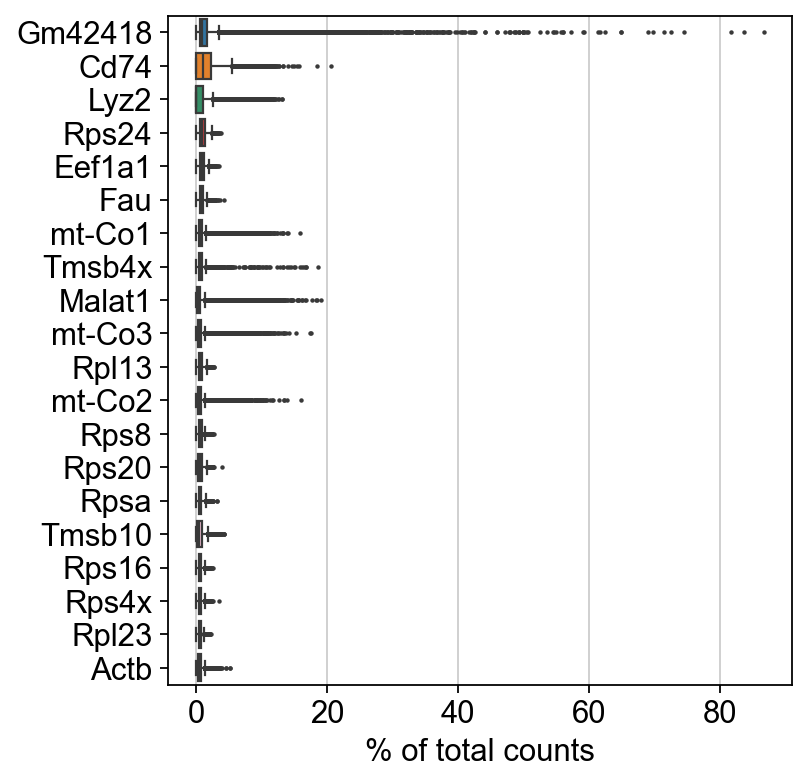

In [5]:
# Plot high expression genes
sc.pl.highest_expr_genes(adata, n_top=20)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


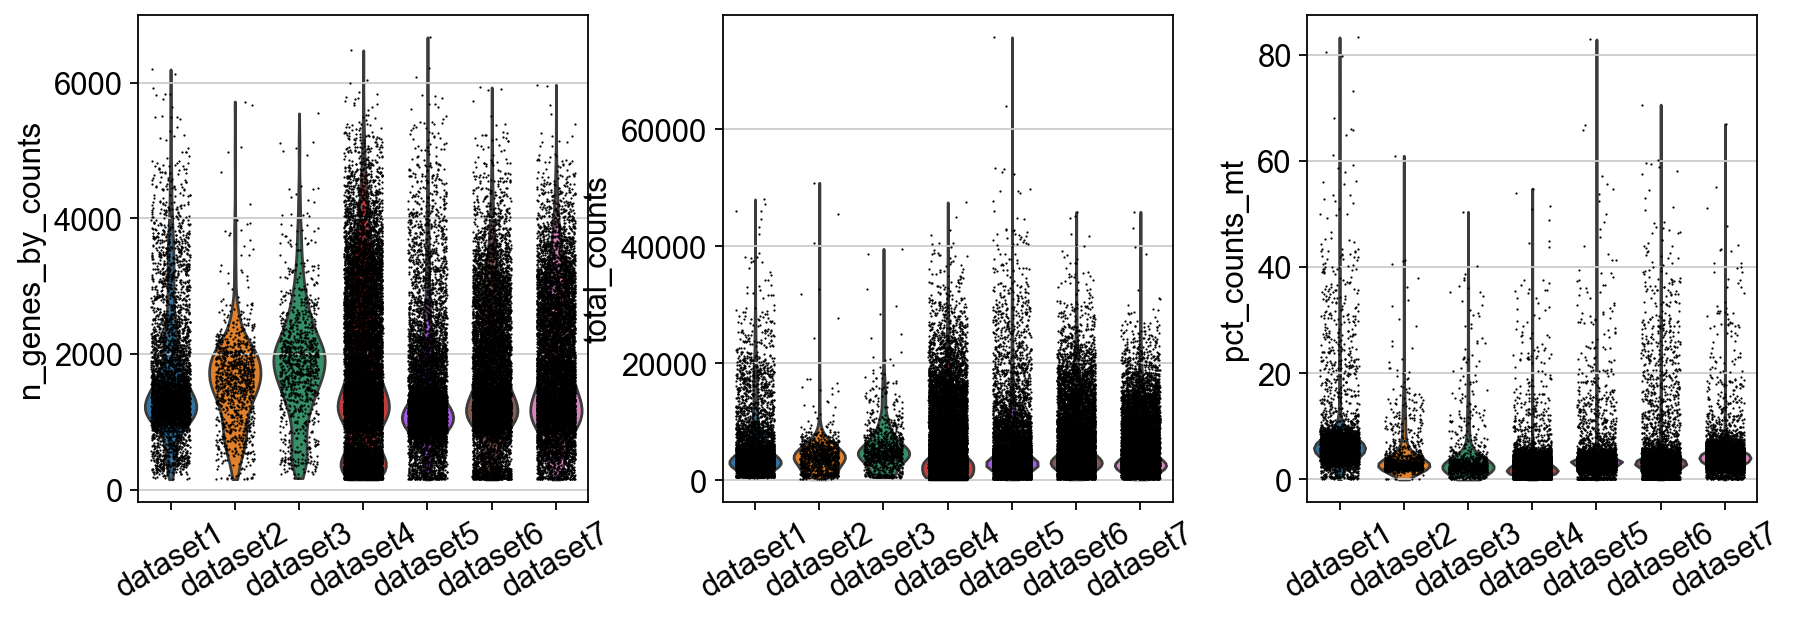

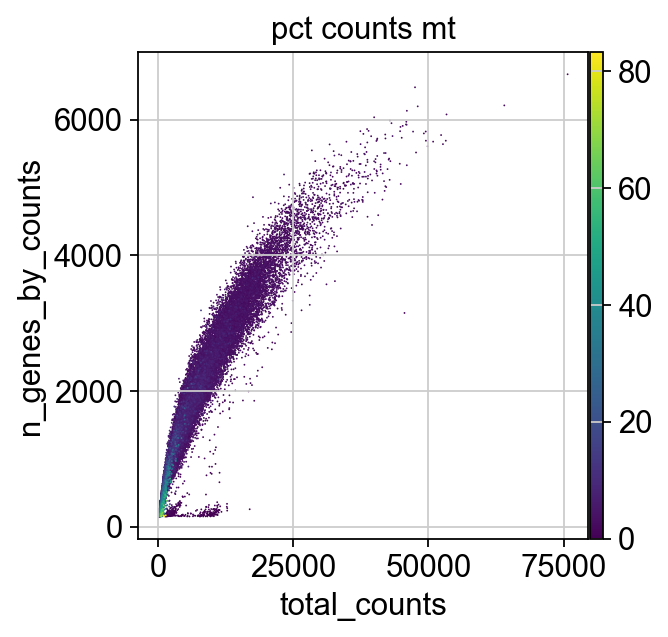

In [6]:
### group gene groups of intrest for QC
adata.var["mt"] = adata.var_names.str.startswith("mt-") # annotate the group of mitochondrial genes as "mt"
adata.var["ribo"] = adata.var_names.str.startswith(("Rps","Rpl")) # Ribosomal genes
adata.var_names[adata.var_names.str.contains("^Hb[^(p)]")] # print hemoglobin gene names 
adata.var["hb"] = adata.var_names.str.contains("^Hb[^(p)]") # hemoglobin genes
'''
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
'''
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

# Plot the qc metrics
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.3,
    multi_panel=True,
    groupby='dataset',
    rotation=30
)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

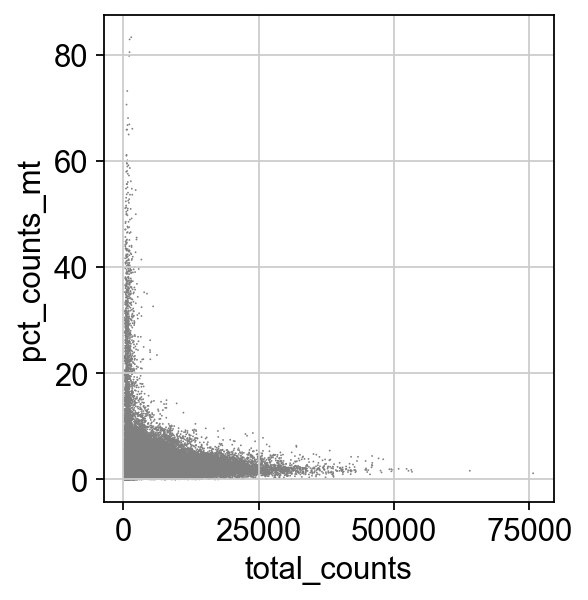

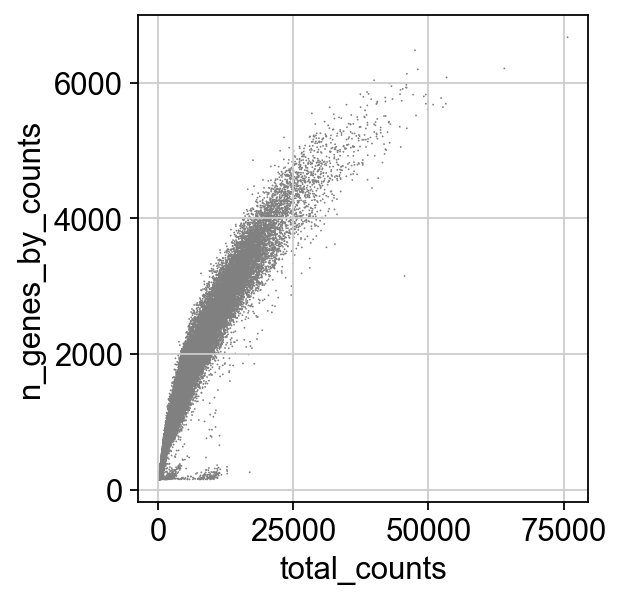

In [7]:
### Remove low quality cells

# Plot
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")
# Remove
adata = adata[adata.obs.n_genes_by_counts < 3000, :] # was 2500
adata = adata[adata.obs.pct_counts_mt < 10, :].copy()

In [8]:
adata

AnnData object with n_obs × n_vars = 37125 × 17912
    obs: 'dataset', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'dataset_colors'

In [9]:
# Remove doublets
sc.pp.scrublet(adata, batch_key="dataset")

Running Scrublet
filtered out 3982 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 39.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.7%
filtered out 6660 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata

In [10]:
# number of predicted soublets
len(list(filter(None, adata.obs['predicted_doublet'])))
# Remove predicted doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
adata

AnnData object with n_obs × n_vars = 36836 × 17912
    obs: 'dataset', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'dataset_colors', 'scrublet'

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Users/guyshani/Documents/PHD/Aim_2/process_sc/.venv_metacells/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


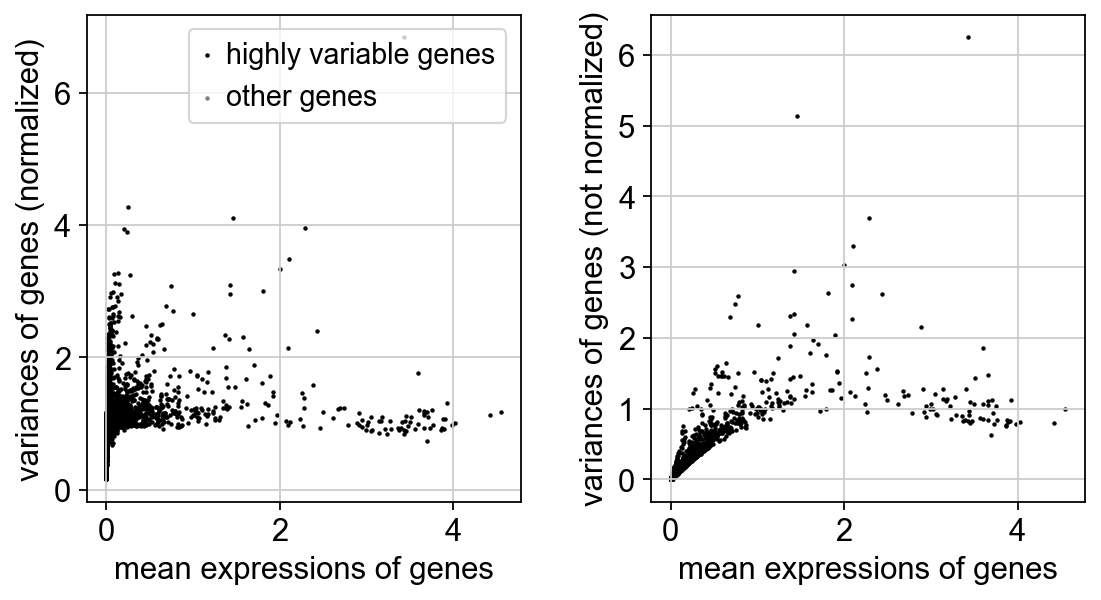

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:17)


In [11]:
### Normalize
# Save count data
adata.layers["counts"] = adata.X.copy()
# Total count normalize (library size correct), the data matrix to 10,000 reads per cell
# so counts become compareable among cells
sc.pp.normalize_total(adata, target_sum=1e4)
# log transform
sc.pp.log1p(adata)
adata.raw = adata # set ,raw attribute of the object to normalized raw gene expression.

### Feature selection
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata, 
                            flavor="seurat_v3",
                            n_top_genes=5000, 
                            batch_key="dataset",
                            subset=True)
sc.pl.highly_variable_genes(adata) # plot

adata.layers["log_normalized"] = adata.X.copy()
# Regress out effects of total counts per cell and nitochondrial gene expression.
# scale the data to unit variance
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
# Scale each gene to unit variance and clip values exceeding 10 STD
sc.pp.scale(adata, max_value=10)

computing PCA
    with n_comps=50
    finished (0:00:07)


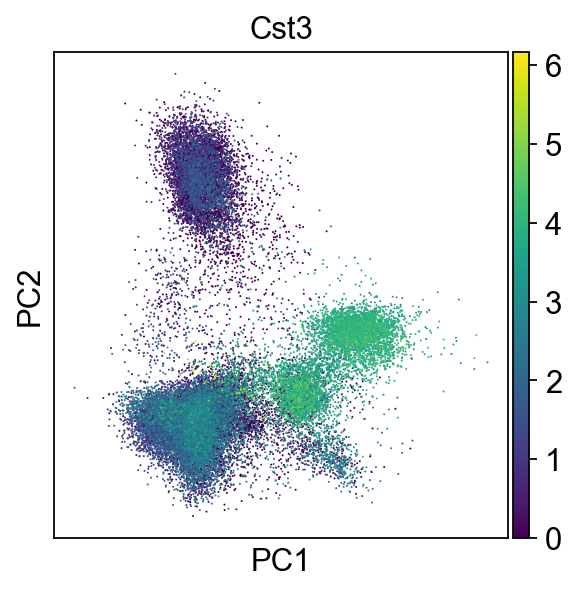

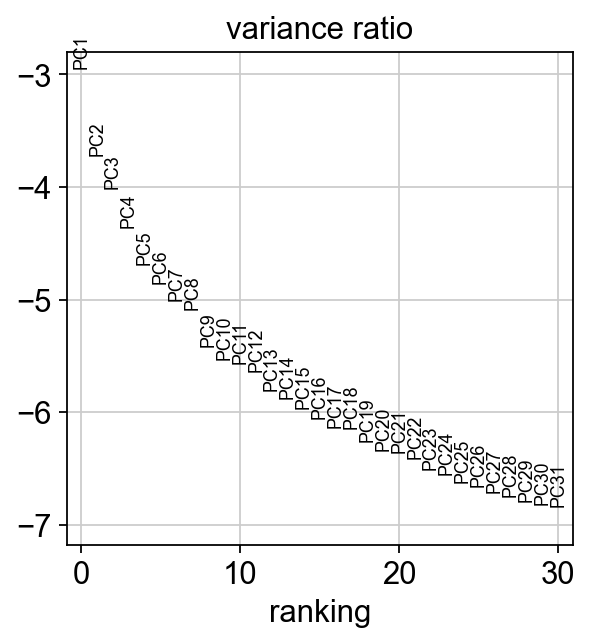

In [12]:
### PCA
sc.tl.pca(adata, svd_solver="arpack") # Run PCA
# make scatter plot in PCA coordinates
sc.pl.pca(adata, color="Cst3")
# Inspect contribution of each PC to the total variance in the data.
sc.pl.pca_variance_ratio(adata, log=True)

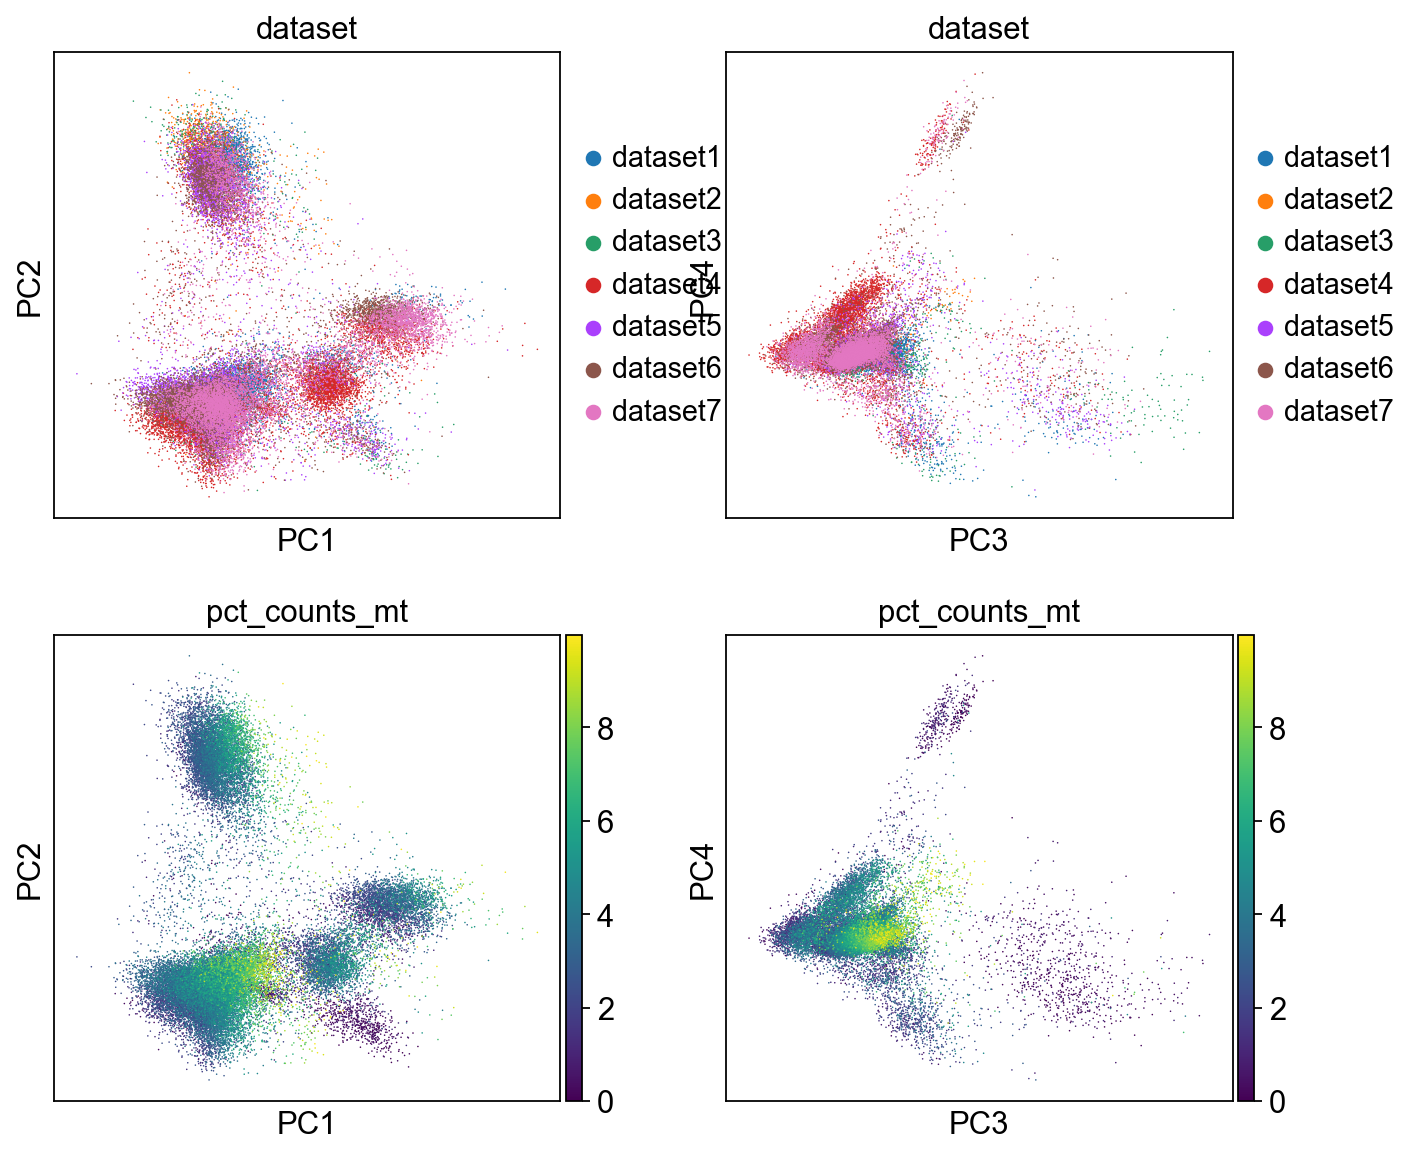

In [13]:
# Check for cells quality
# I dont want to see any clustering based on dataset or mitochondrial genes levels
sc.pl.pca(
    adata,
    color=["dataset", "dataset", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

In [14]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:14)


In [16]:
### Integration
# Harmony
sce.pp.harmony_integrate(adata, 'dataset')

2025-02-18 10:42:05,430 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-02-18 10:42:14,752 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-18 10:42:14,827 - harmonypy - INFO - Iteration 1 of 10
2025-02-18 10:42:20,921 - harmonypy - INFO - Iteration 2 of 10
2025-02-18 10:42:26,782 - harmonypy - INFO - Iteration 3 of 10
2025-02-18 10:42:32,845 - harmonypy - INFO - Iteration 4 of 10
2025-02-18 10:42:40,036 - harmonypy - INFO - Iteration 5 of 10
2025-02-18 10:42:44,916 - harmonypy - INFO - Converged after 5 iterations


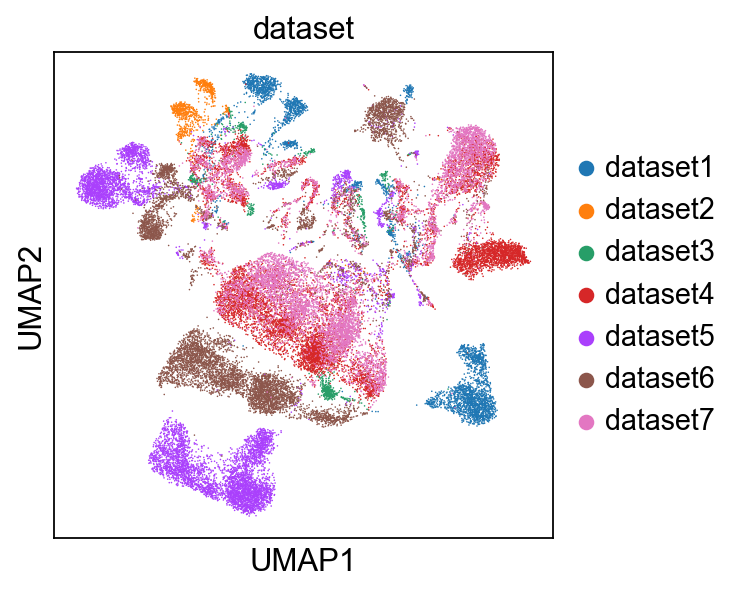

/Users/guyshani/Documents/PHD/Aim_2/process_sc/.venv_metacells/lib/python3.11/site-packages/scvi/dataloaders/_data_splitting.py:258: UserWarning: 1 cells moved from training set to validation set. if you want to avoid it please use train_size parameter during train.
  self.n_train, self.n_val = validate_data_split(
/Users/guyshani/Documents/PHD/Aim_2/process_sc/.venv_metacells/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/guyshani/Documents/PHD/Aim_2/process_sc/.venv_metacells/lib/python3.11

Epoch 217/217: 100%|██████████| 217/217 [19:17<00:00,  5.22s/it, v_num=1, train_loss_step=878, train_loss_epoch=877]    

`Trainer.fit` stopped: `max_epochs=217` reached.


Epoch 217/217: 100%|██████████| 217/217 [19:17<00:00,  5.33s/it, v_num=1, train_loss_step=878, train_loss_epoch=877]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)


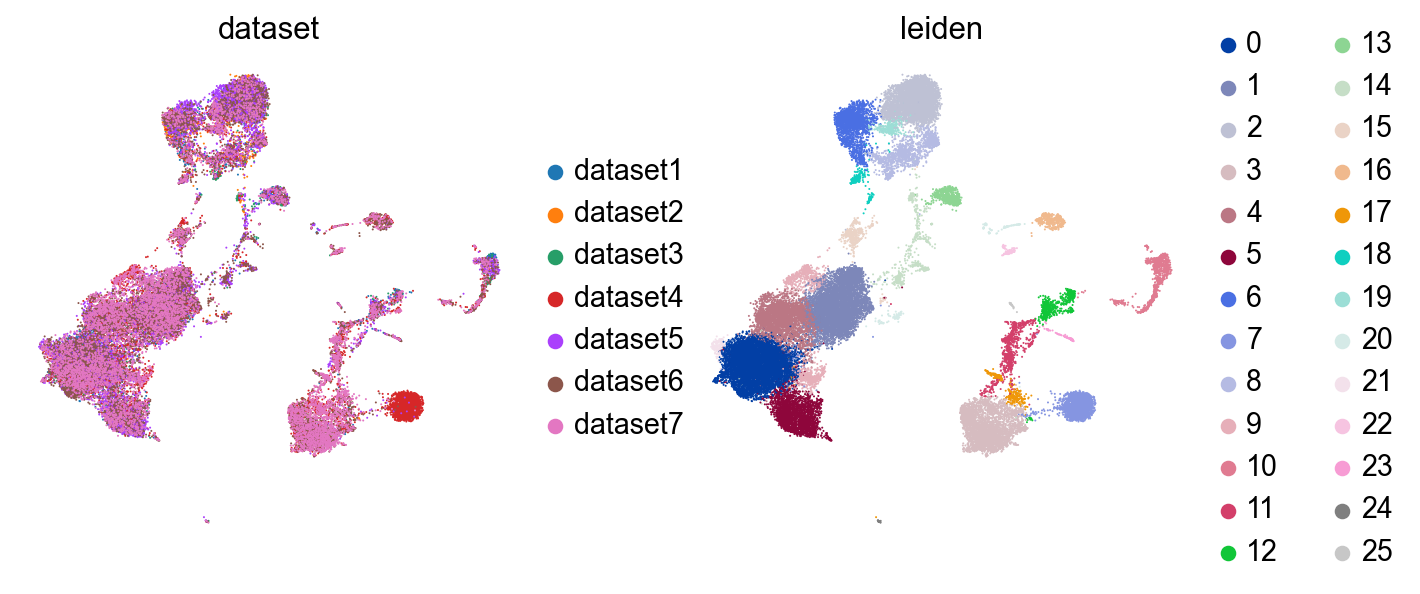

In [17]:
### Integration
sc.pl.umap(
    adata,
    color="dataset",
    # Setting a smaller point size to get prevent overlap
    size=2,
)
# Run integration calculations
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="dataset")
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train(accelerator='mps', devices='auto') # on mac computers
# Latent representation of the data
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
# Cluster the dataset and visualize
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)
# visualize integration
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["dataset", "leiden"],
    frameon=False,
    ncols=2,
)

computing PCA
    with n_comps=50
    finished (0:00:06)


Embeddings: 100%|██████████| 3/3 [03:25<00:00, 68.34s/it]


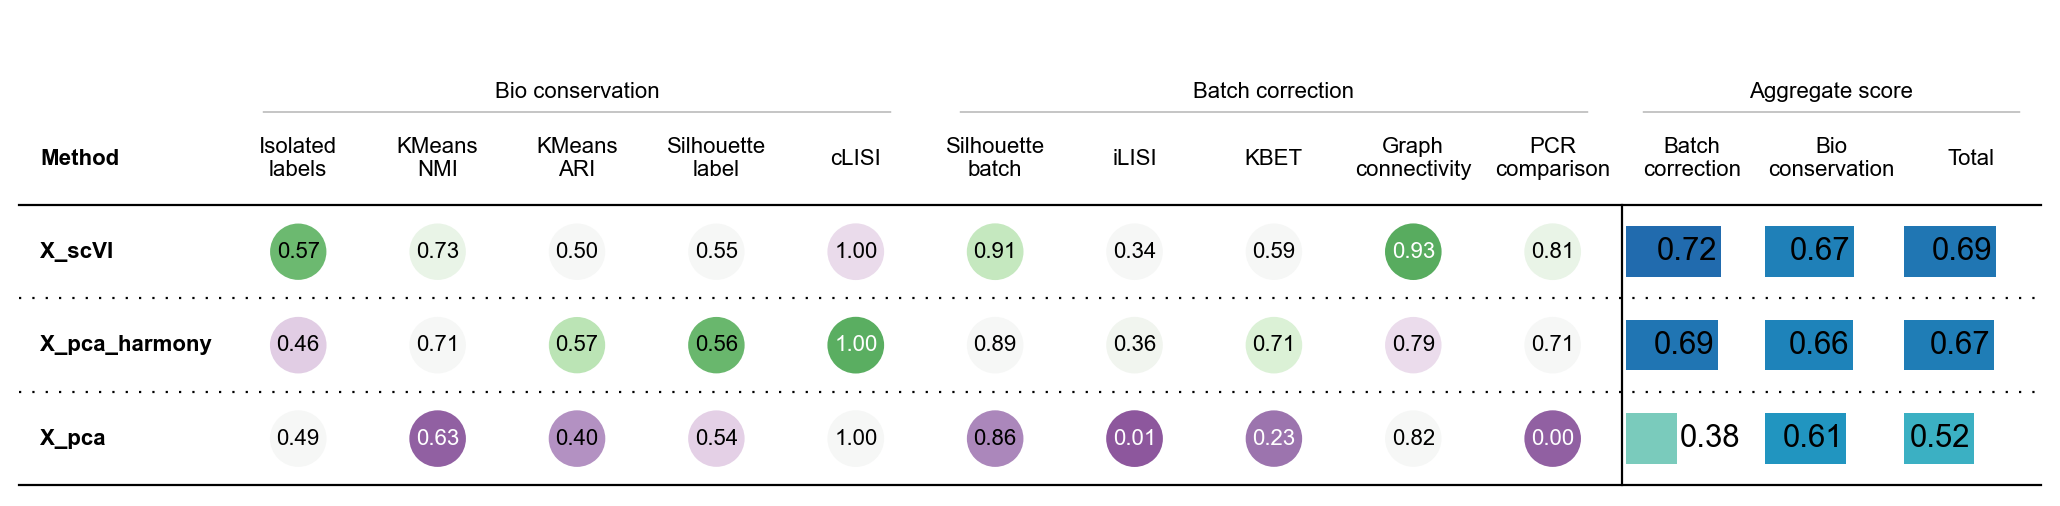

In [19]:
## Integration QC
bm = Benchmarker(
    adata,
    batch_key="dataset",
    label_key="leiden",
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY,'X_pca_harmony'], # unintegrated, scvi integration
    n_jobs=6,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)
#df = bm.get_results(min_max_scale=False)

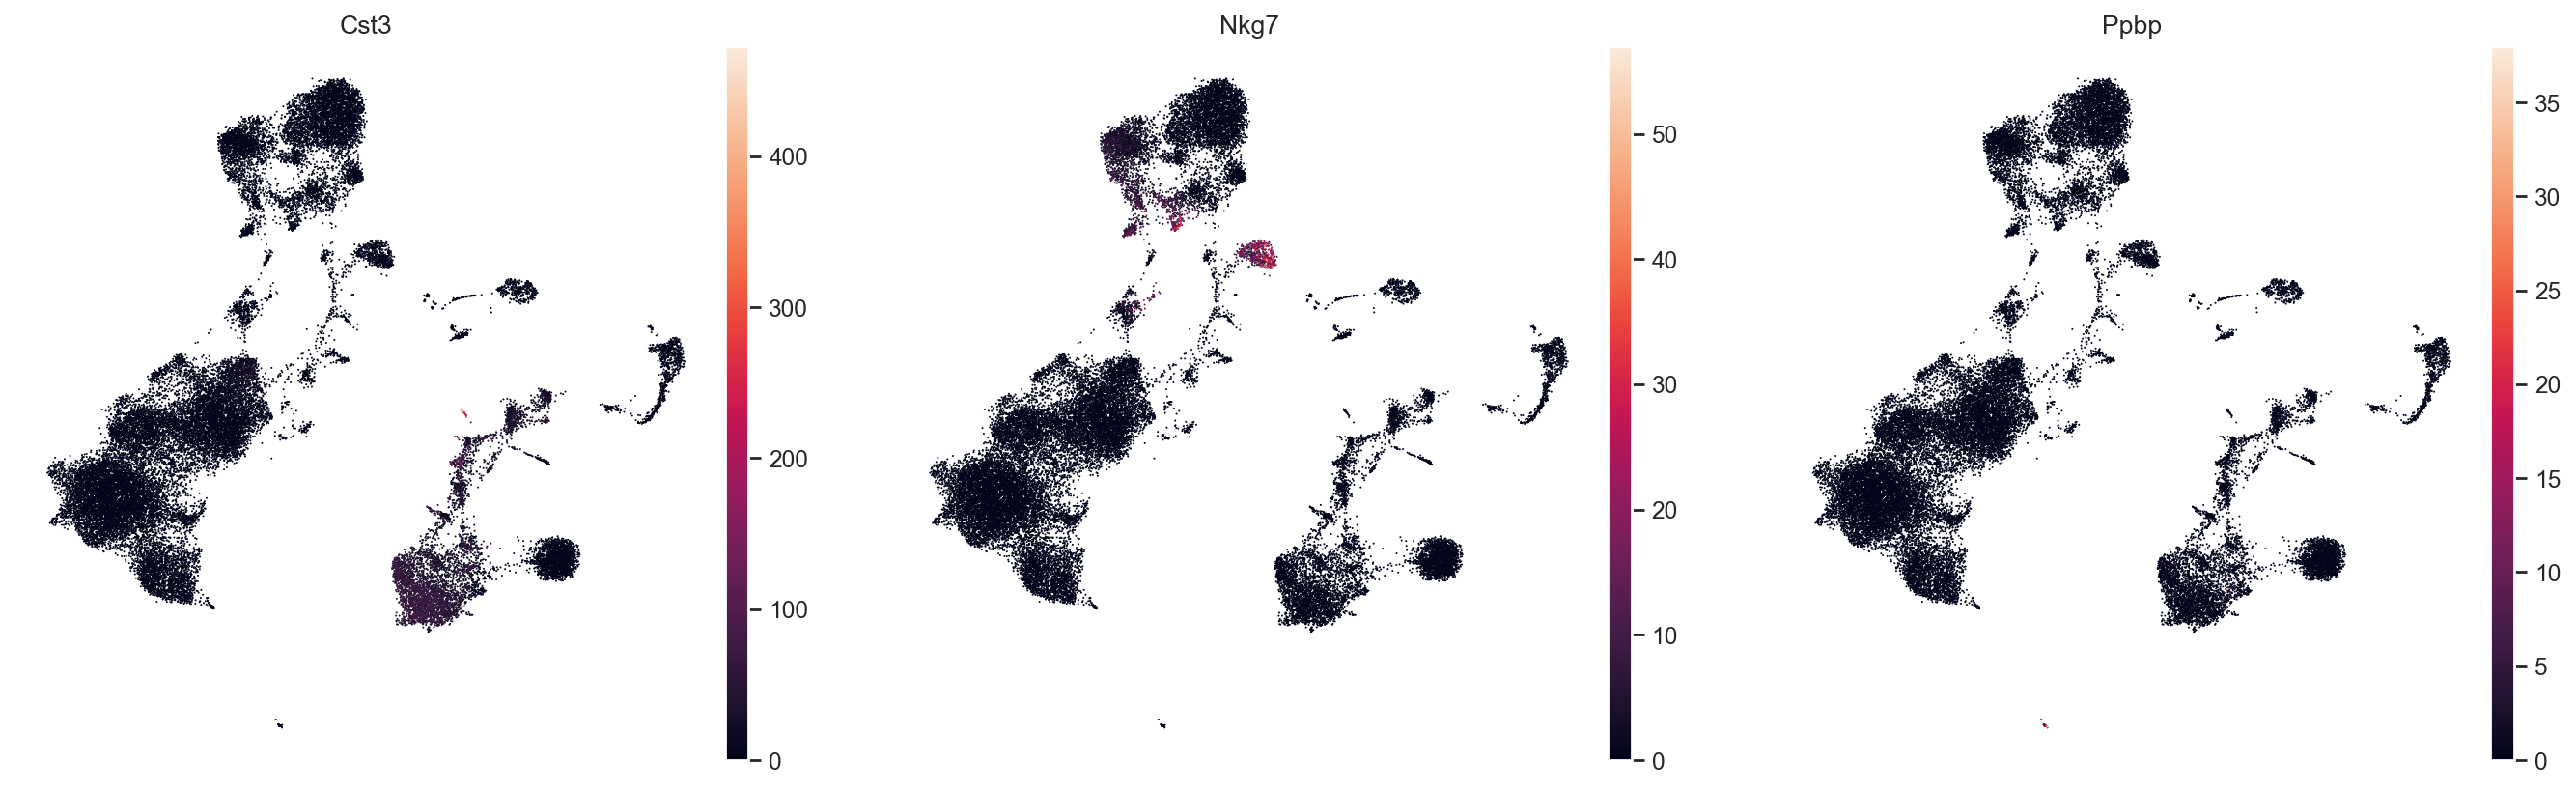

Epoch 279/400:  70%|██████▉   | 278/400 [1:28:47<38:58, 19.16s/it, v_num=1, train_loss_step=12.5, train_loss_epoch=12.3]


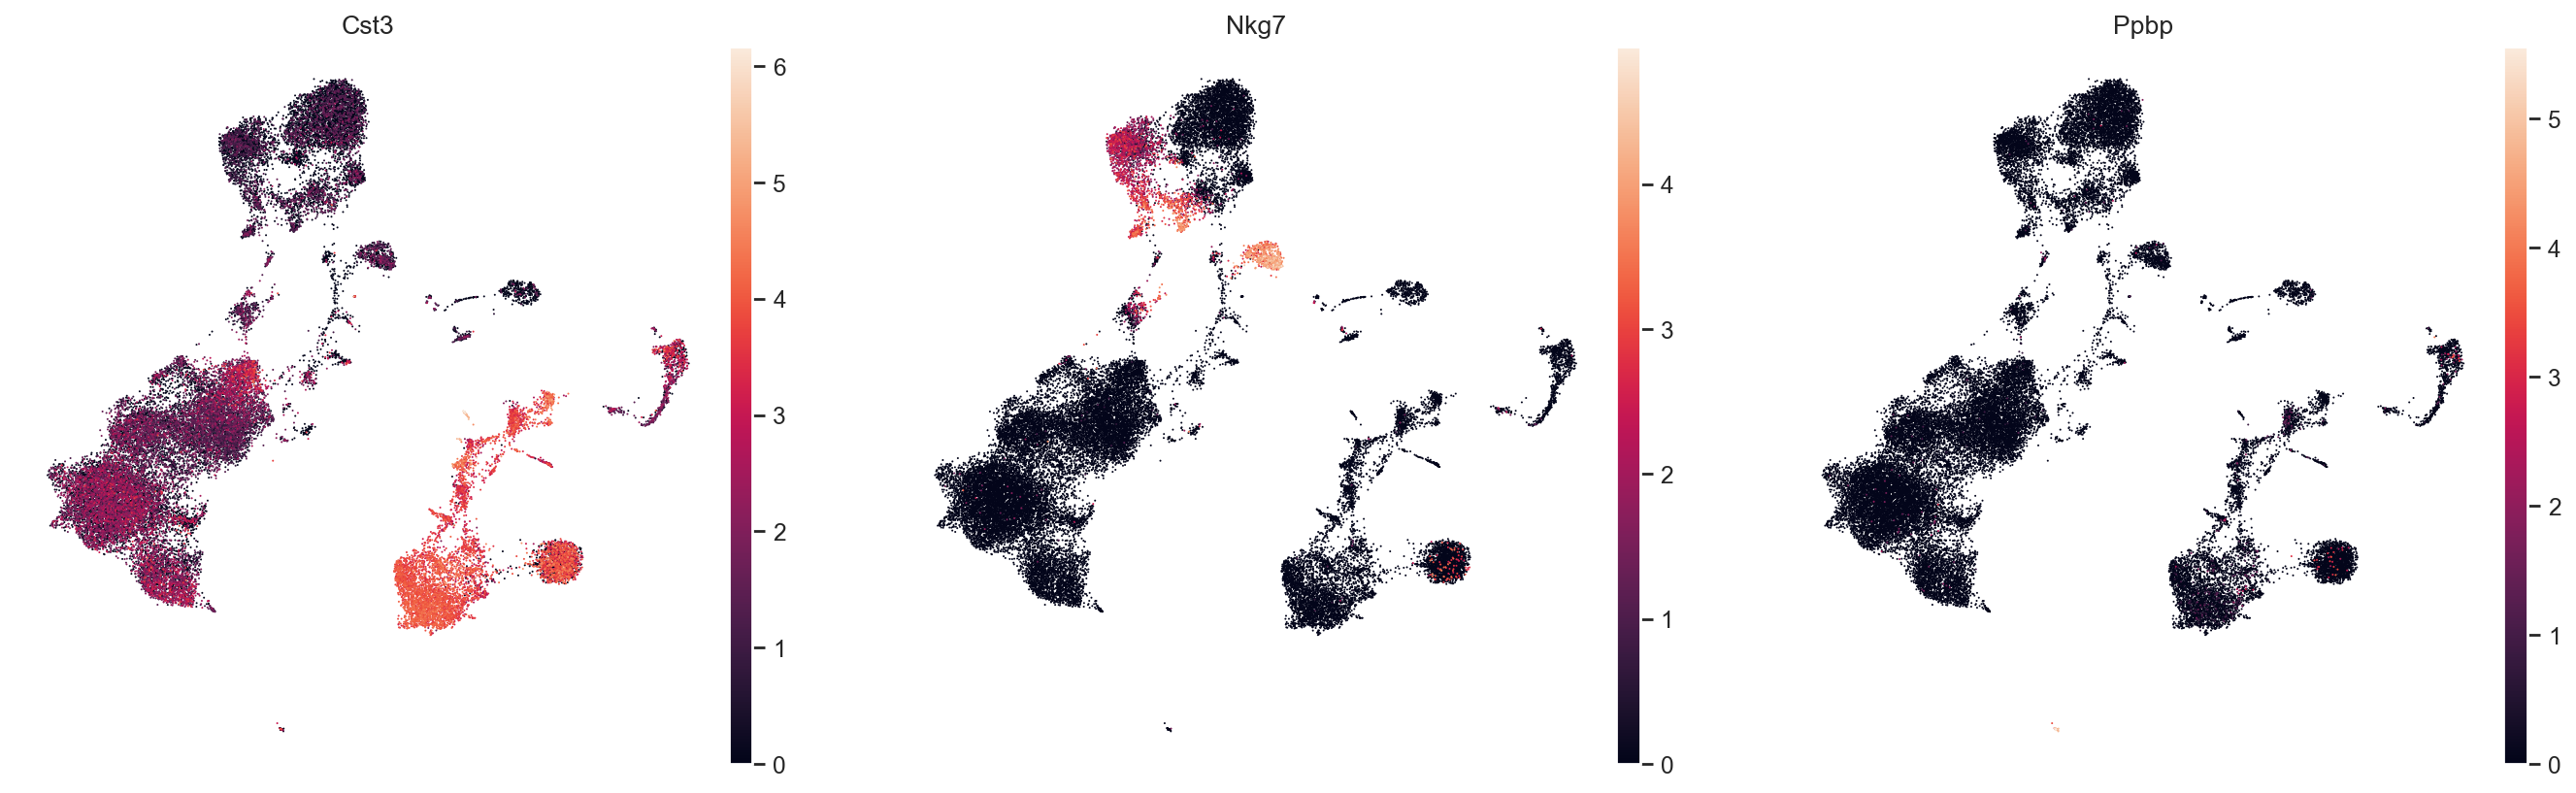

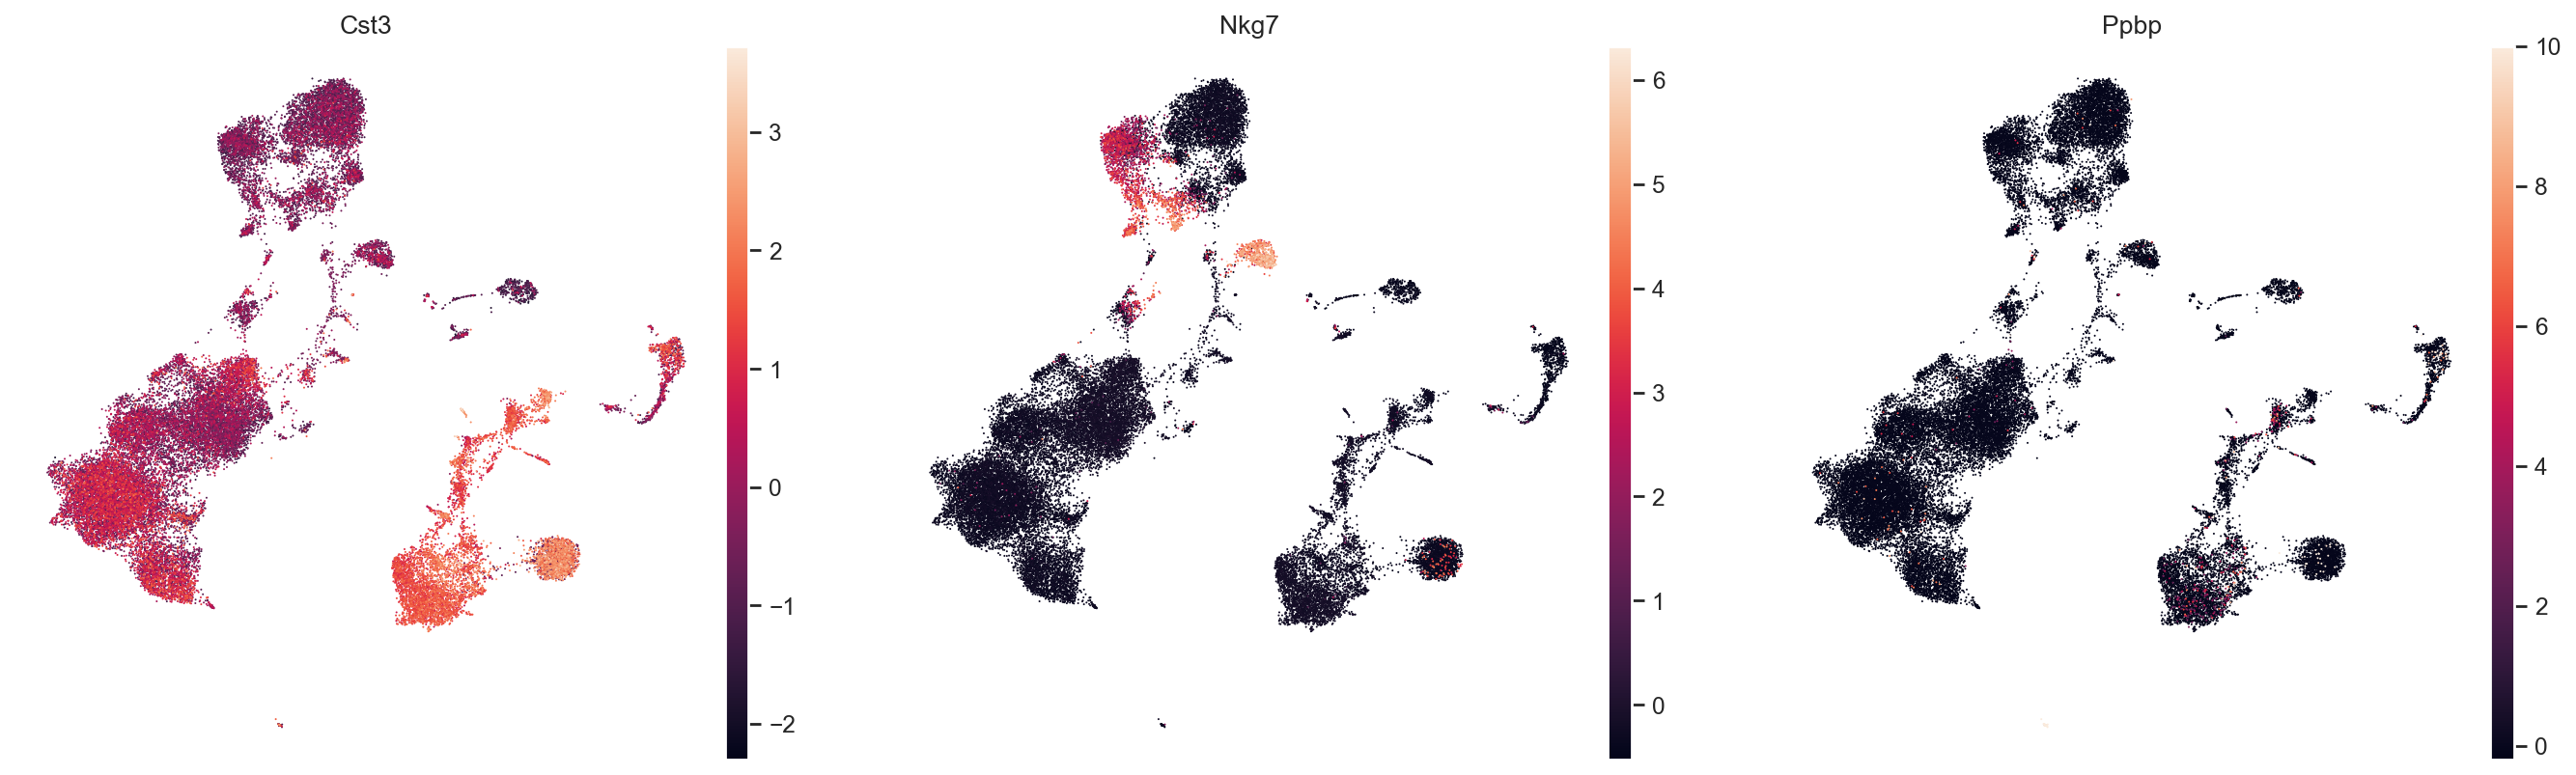

In [ ]:
# Plot UMAPs (sanity check)
sc.pl.umap(adata, color=["Cst3", "Nkg7", "Ppbp"], layer="counts") # Raw counts
sc.pl.umap(adata, color=["Cst3", "Nkg7", "Ppbp"], layer="log_normalized") # Normalized and logarithmized counts
sc.pl.umap(adata, color=["Cst3", "Nkg7", "Ppbp"], use_raw=False) # Scaled and corrected counts

In [20]:
# save temp results
adata.write(results_file)

In [21]:
####### Cell typing
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
#torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [22]:
def create_marker_matrix(adata, marker_file):
    """
    Create a binary matrix indicating which genes are markers for which cell types.
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data matrix containing gene names
    marker_file : str
        Path to the marker file containing cell types and their markers
        
    Returns:
    --------
    pd.DataFrame
        Binary matrix where rows are genes and columns are cell types
    """
    # Read the marker file
    markers_df = pd.read_csv(marker_file, sep='\t')
    markers_df.columns = ['organisem','tissue','dis','typ','cellName','cellMarker']
    
    # Get unique cell types
    cell_types = markers_df['cellName'].unique()
    
    # Get all genes from the anndata object
    genes = adata.var_names.tolist()
    
    # Create an empty DataFrame for the binary matrix
    binary_matrix = pd.DataFrame(0, index=genes, columns=cell_types)
    
    # Process each cell type
    for cell_type in cell_types:
        # Get all markers for this cell type
        cell_markers = markers_df[markers_df['cellName'] == cell_type]['cellMarker'].tolist()
        
        # Process each marker entry (which might contain multiple genes)
        for marker_entry in cell_markers:
            # Split the marker entry by comma and strip whitespace
            markers = [m.strip() for m in marker_entry.split(',')]
            
            # Set 1 for each marker gene that exists in our gene list
            for marker in markers:
                if marker in genes:
                    binary_matrix.loc[marker, cell_type] = 1
    
    return binary_matrix

In [23]:
## Load marker data
marker_matrix = create_marker_matrix(adata, "/Users/guyshani/Documents/PHD/Aim_2/process_sc/blood_markers.txt")
# Keeps only rows that have at least one non-zero value
marker_matrix = marker_matrix[marker_matrix.any(axis=1)]
marker_matrix

In [57]:
### Cell typing using CellAssign
lib_size = adata.layers['counts'].sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)
bdata = adata[:, marker_matrix.index].copy()

In [ ]:
# setup the CellAssign class
scvi.external.CellAssign.setup_anndata(bdata, layer="counts",size_factor_key="size_factor")
blood_model = CellAssign(bdata, marker_matrix)
# Train the model on the marker genes
blood_model.train(accelerator='mps', devices='auto')

/Users/guyshani/Documents/PHD/Aim_2/process_sc/.venv_metacells/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/Users/guyshani/Documents/PHD/Aim_2/process_sc/.venv_metacells/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/guyshani/Documents/PHD/Aim_2/process_sc/.venv_metacells/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [05:20<00:00,  1.24it/s, v_num=1, train_loss_step=12.5, train_loss_epoch=12.3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:20<00:00,  1.25it/s, v_num=1, train_loss_step=12.5, train_loss_epoch=12.3]


<Axes: xlabel='epoch'>

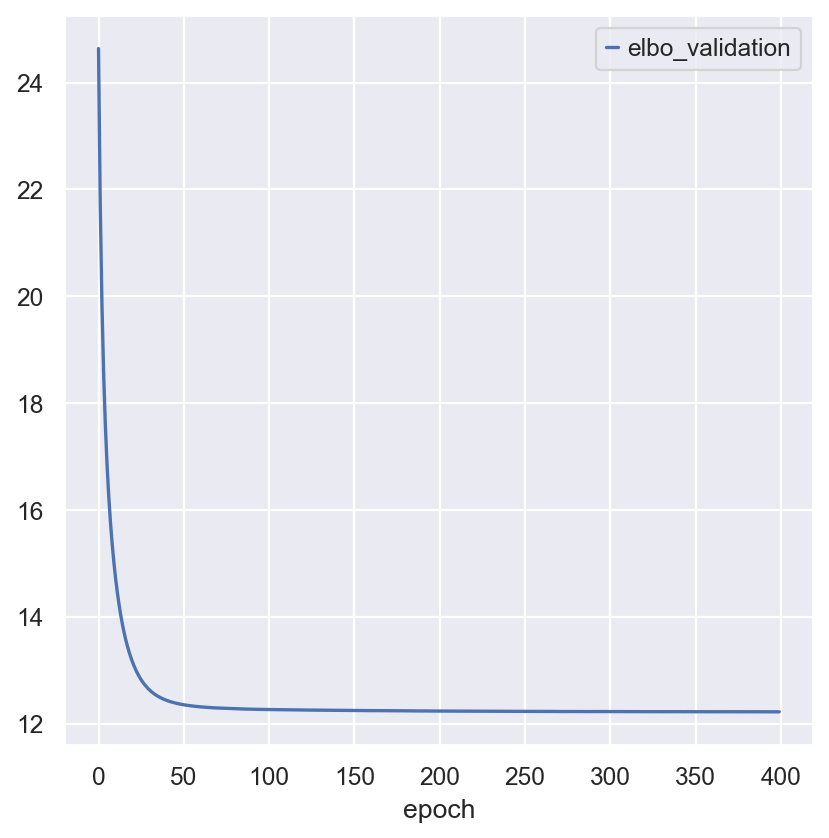

In [64]:
# Check convergence
blood_model.history["elbo_validation"].plot()

In [ ]:
## Make cell type predictions and inspect top cells
predictions = blood_model.predict()
predictions.head()

B cell  Natural killer cell      Monocyte  Dendritic cell  \
0  6.736215e-06         6.410152e-16  2.159791e-08    1.766387e-02   
1  4.300714e-06         1.802489e-11  6.158541e-09    8.631770e-10   
2  1.140758e-26         7.773828e-29  4.083819e-29    1.669758e-25   
3  3.750864e-13         7.628718e-18  6.166017e-16    3.984388e-14   
4  1.000000e+00         2.611442e-17  9.576984e-12    1.694338e-12   

    CD4+ T cell   CD8+ T cell  Activated CD8+ T cell  Inflammatory monocyte  \
0  4.733988e-07  5.741533e-08           6.912482e-11           2.320881e-01   
1  9.995233e-01  4.560730e-04           1.489500e-05           2.257543e-09   
2  9.493152e-18  4.525014e-04           9.995481e-01           7.690958e-25   
3  9.999771e-01  1.821691e-05           4.436167e-06           1.162248e-15   
4  3.573859e-10  4.874590e-11           3.384380e-13           2.857536e-10   

   Germinal center B cell  Induced regulatory T (Treg) cell  \
0            8.712352e-07                      6.437884e-11   
1            2.482298e-09                      1.621633e-10   
2            5.623442e-30                      5.407392e-23   
3            2.120426e-16                      4.951779e-11   
4            8.006405e-08                      4.648509e-19   

   Regulatory T (Treg) cell  Ly6c+ monocyte  Plasmacytoid dendritic cell  \
0              1.125927e-08    7.466786e-02                 9.439375e-12   
1              1.030366e-06    2.286713e-09                 1.505520e-10   
2              2.312130e-22    4.351578e-31                 8.699351e-33   
3              6.592908e-10    1.380678e-15                 9.282233e-18   
4              5.606380e-12    7.584582e-11                 4.404667e-10   

     Macrophage  
0  6.755713e-01  
1  2.198715e-10  
2  1.822150e-31  
3  2.627851e-17  
4  4.177379e-07

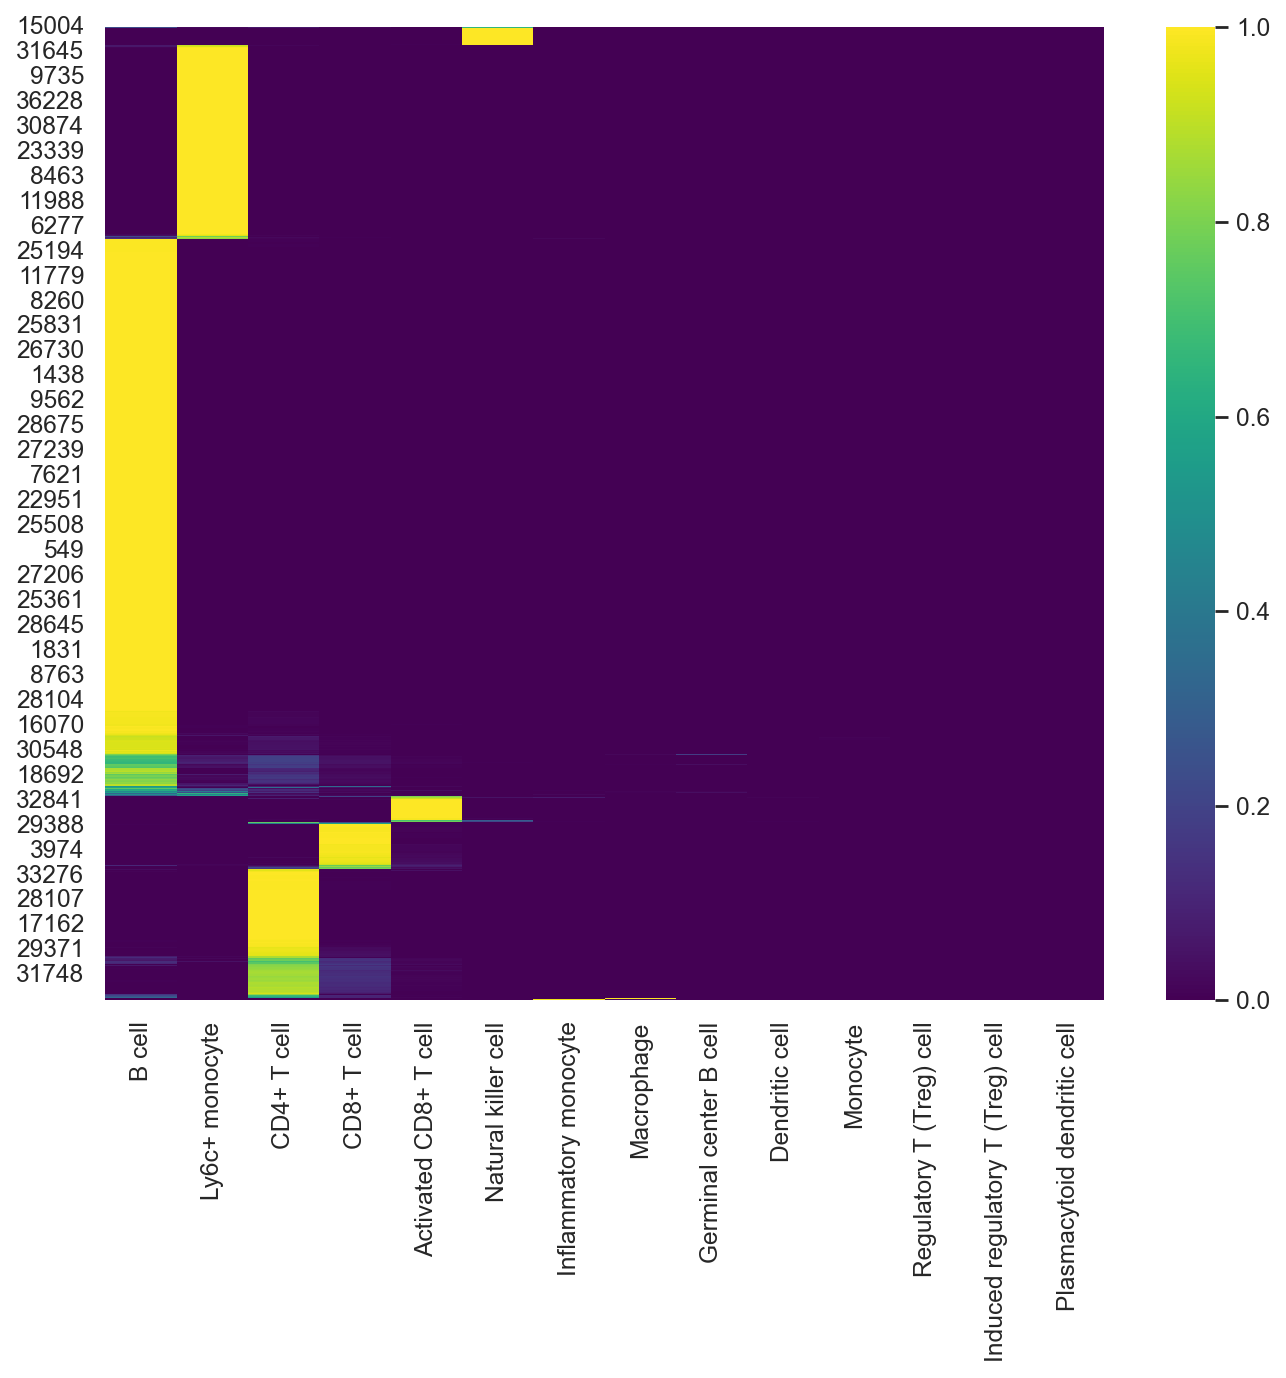

In [71]:
## Visualize predicted probabilities
# Compute linkage matrices for both rows and columns
row_linkage = linkage(predictions, method='average', metric='euclidean')
col_linkage = linkage(predictions.T, method='average', metric='euclidean')

# Get the reordering indices from the linkages 
row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

# Reorder the data according to the clustering
reordered_data = predictions.iloc[row_order, col_order]

# Create figure with appropriate size
plt.figure(figsize=(10, 8))

# Create heatmap with reordered data
sns.heatmap(reordered_data, cmap='viridis')
plt.show()

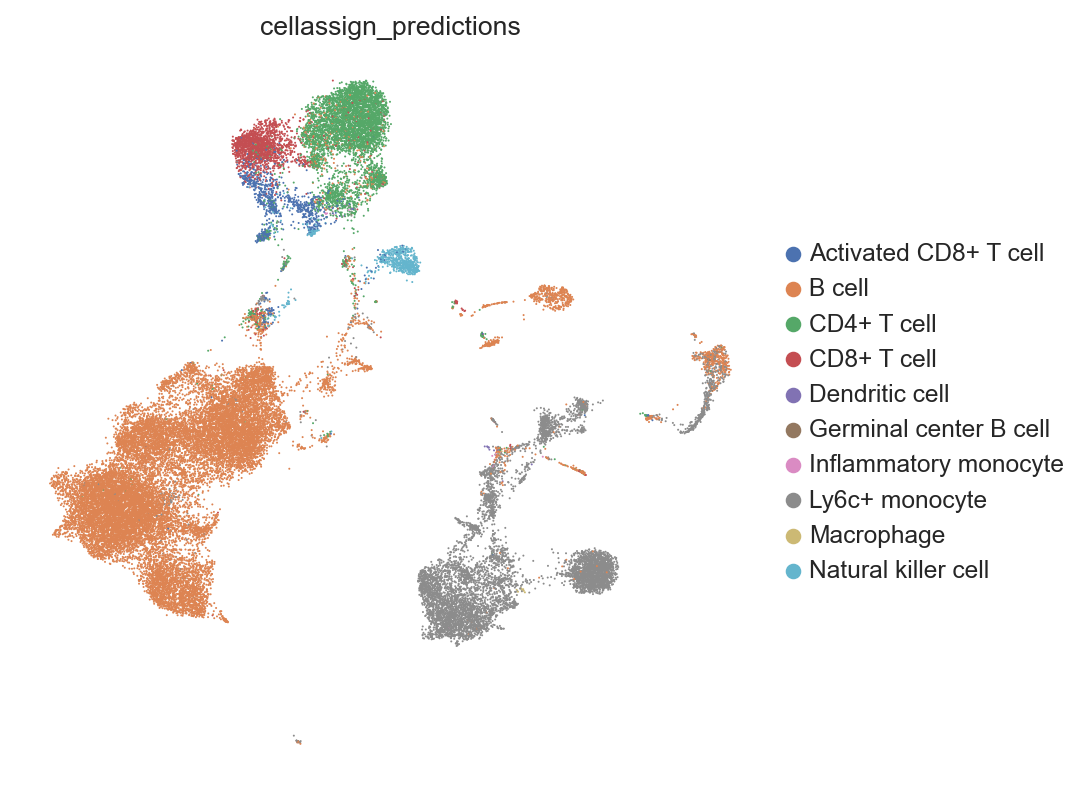

In [74]:
# add predictions to AnnData objects
bdata.obs["cellassign_predictions"] = predictions.idxmax(axis=1).values # reduced object
adata.obs["cellassign_predictions"] = predictions.idxmax(axis=1).values # main object
# celltype is the original CellAssign prediction
sc.pl.umap(
    bdata,
    #color=["celltype", "cellassign_predictions"],
    color="cellassign_predictions",
    frameon=False,
    ncols=2)

In [ ]:
######  Save final results
adata.write(results_file) # save object
adata.write(results_file, compression="gzip") # save object with compressing
adata.raw.to_adata().write("./write/pbmc3k_withoutX.h5ad") # remove the dense and corrected data matrix.

In [19]:
### Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) # Use seurat parameters
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
# Compute UMAP
sc.tl.umap(adata)
# Plot UMAPs
sc.pl.umap(adata, color=["Cst3", "Nkg7", "Ppbp"]) # Normalized and logarithmized counts
sc.pl.umap(adata, color=["Cst3", "Nkg7", "Ppbp"], use_raw=False) # Scaled and corrected counts

In [20]:
### Clustering
# Leiden graph clustering
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)
# Plot
sc.pl.umap(adata, color=["leiden", "Cst3", "Nkg7"])

In [21]:
### Find marker genes
# Compute a ranking for highly differential genes in each cluster via Mann-Whitney-U
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
## can use other tools for differential testing here, such as MAST, limma,DESeq2, diffxpy
# Find marker genes using logistic regression (Natranos et al. 2018), a multi variate approach
#sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
# Print 10 top ranked genes per cluster
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

In [22]:
## Create a table with scores and groups
# requires a p-value (logistic regression do not apply)
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

In [23]:
### Differential gene expression and plots
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon") # Compare cluster 0 to cluster 1
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20) # score vs ranking
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8) # violin plot
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference='rest', method="wilcoxon") # Compare cluster 0 to rest
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8) # violin plot 
## Violin plot for gene expression across clusters
sc.pl.violin(adata, ["Cst3", "Nkg7", "Ppbp"], groupby="leiden")

In [ ]:
## Rename clusters
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)
# Plot UMAP and save
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)
# visualize marker genes
sc.pl.dotplot(adata, marker_genes, groupby="leiden"); # dotplot
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden"); # violinplot


In [ ]:
adata
adata.write(results_file) # save object
adata.write(results_file, compression="gzip") # save object with compressing
adata.raw.to_adata().write("./write/pbmc3k_withoutX.h5ad") # remove the dense and corrected data matrix.